In [3]:
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import math
from sklearn.naive_bayes import GaussianNB
import scipy as sc
from scipy import stats
from matplotlib.ticker import FuncFormatter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score,recall_score, f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve,auc
import seaborn as sns

%matplotlib inline

In [6]:
PATHDATA = '../data/audiosData.csv'
df = pd.read_csv(PATHDATA, header=None)
data = df.values

In [7]:
X = data[:,0:-2]
Y = data[:,-1]
print('Tamaño dataSet', X.shape)
print('\n')
Y=  np.reshape(Y,(np.size(Y,0),1))
groups = data[:,-2:-1]


Tamaño dataSet (5200, 162)




In [8]:
n_classes=len(np.unique(Y))
print('Número de clases:', n_classes)

Número de clases: 4


In [9]:
n_groups = len(np.unique(groups))
print('Número de hablantes diferentes', n_groups)

Número de hablantes diferentes 1499


## Dividir el dataset (train/test) 0.8/0.2

In [10]:
gss = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=0)
for train_index,test_index in gss.split(X,Y,groups=groups):
    X_train_original, X_test_original = X[train_index],X[test_index]
    Y_train__original, Y_test__original = Y[train_index], Y[test_index]
    groups_original = groups[train_index]

In [11]:
X_train_original.shape

(4162, 162)

In [12]:
X_test_original.shape

(1038, 162)

In [13]:
def build_model(model, parameters, folds, train_size, X,Y,groups_original):
  acc_scorer = make_scorer(accuracy_score)
  recalls = make_scorer(recall_score,average='micro')##buscar por que micro
  precision = make_scorer(precision_score,average='micro')
  f1 = make_scorer(f1_score,average='micro')
  scores =  {'recalls':recalls,'precision':precision,'f1':f1,'Accuracy': make_scorer(accuracy_score)}
  gss = GroupShuffleSplit(n_splits=folds, train_size=train_size, random_state=0)
  model = GridSearchCV(model,parameters,scores,-1,refit='Accuracy',return_train_score=True, cv=gss.split(X, Y, groups=groups_original))
  model.fit(X,Y)
  return model 

In [14]:
FOLDS = 10
TRAIN_SIZE = 0.8

In [15]:
gnb = GaussianNB()
modelGNB_trained = build_model(gnb, {}, FOLDS, TRAIN_SIZE, X_train_original,Y_train__original,groups_original)

/Users/deiry/ML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/deiry/ML/semillero/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
pdGNB = pd.DataFrame(modelGNB_trained.cv_results_)

In [17]:
pdGNB

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,split0_test_recalls,split1_test_recalls,split2_test_recalls,split3_test_recalls,split4_test_recalls,...,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.091598,0.073888,0.055727,0.015634,{},0.523041,0.460137,0.446629,0.479042,0.465416,...,0.478551,0.482717,0.477788,0.487412,0.482057,0.484385,0.469382,0.479456,0.478702,0.005467


In [18]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
parameters = {'n_estimators':[1,5,7],'max_depth':[3,5,9]}
modelCLF_trained = build_model(clf, parameters, FOLDS, TRAIN_SIZE, X_train_original,Y_train__original,groups_original)

/Users/deiry/ML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/deiry/ML/semillero/lib/python3.7/site-packages/sklearn/model_selection/_search.py:715: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [19]:
pdCLF = pd.DataFrame(modelCLF_trained.cv_results_)
pdCLF

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_recalls,split1_test_recalls,split2_test_recalls,...,split2_train_Accuracy,split3_train_Accuracy,split4_train_Accuracy,split5_train_Accuracy,split6_train_Accuracy,split7_train_Accuracy,split8_train_Accuracy,split9_train_Accuracy,mean_train_Accuracy,std_train_Accuracy
0,0.080814,0.044869,0.028711,0.016674,3,1,"{'max_depth': 3, 'n_estimators': 1}",0.367512,0.376993,0.372191,...,0.416522,0.416892,0.381686,0.466920,0.419557,0.440906,0.411463,0.443689,0.419487,0.024145
1,0.126230,0.006310,0.021822,0.002376,3,5,"{'max_depth': 3, 'n_estimators': 5}",0.503456,0.488610,0.429775,...,0.520000,0.534415,0.504382,0.530738,0.526914,0.526332,0.513122,0.521431,0.523904,0.009007
2,0.177502,0.019808,0.026368,0.006012,3,7,"{'max_depth': 3, 'n_estimators': 7}",0.481567,0.485194,0.456461,...,0.552464,0.524797,0.539740,0.552693,0.535586,0.545928,0.540271,0.545670,0.539552,0.009425
3,0.055519,0.008971,0.019461,0.007011,5,1,"{'max_depth': 5, 'n_estimators': 1}",0.404378,0.440774,0.393258,...,0.483188,0.479110,0.506800,0.510831,0.488935,0.541335,0.494419,0.550990,0.506752,0.023430
4,0.178767,0.006908,0.020587,0.003421,5,5,"{'max_depth': 5, 'n_estimators': 5}",0.533410,0.539863,0.532303,...,0.657681,0.654944,0.629495,0.643735,0.658792,0.649112,0.631373,0.642920,0.645813,0.009897
5,0.238544,0.012530,0.024504,0.004795,5,7,"{'max_depth': 5, 'n_estimators': 7}",0.566820,0.569476,0.551966,...,0.668986,0.678389,0.667271,0.697307,0.671950,0.702082,0.666365,0.673071,0.678021,0.012521
6,0.065235,0.003505,0.015198,0.001835,9,1,"{'max_depth': 9, 'n_estimators': 1}",0.438940,0.478360,0.422753,...,0.678841,0.697926,0.677848,0.698185,0.656998,0.666871,0.674811,0.678392,0.675072,0.018226
7,0.262779,0.008569,0.026408,0.009616,9,5,"{'max_depth': 9, 'n_estimators': 5}",0.581797,0.586560,0.551966,...,0.879130,0.862639,0.878815,0.885539,0.875897,0.872627,0.879638,0.883535,0.879553,0.009018
8,0.340398,0.022021,0.022994,0.004191,9,7,"{'max_depth': 9, 'n_estimators': 7}",0.609447,0.555809,0.567416,...,0.911884,0.915540,0.928377,0.915691,0.917464,0.922841,0.918552,0.903636,0.916493,0.006367


In [20]:
best_params_CLF = modelCLF_trained.cv_results_['params'][modelCLF_trained.best_index_]

In [21]:
best_params_CLF

{'max_depth': 9, 'n_estimators': 7}

In [22]:
def Metrics(model,X_test,Y_test):

  y_predicted = model.predict(X_test)
  print('Accuracy: ', accuracy_score(Y_test, y_predicted), '\n')
  report = classification_report(Y_test, y_predicted)
  print("\nclassification report :\n",report )
 
  # Matriz de confusión
  cm = confusion_matrix(Y_test, y_predicted)
  # Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)
  
  #sns.heatmap(cm,annot=True,fmt = "d",linecolor="k",linewidths=3)
  #plt.title("Matriz de confusión",fontsize=20)
   
    
  return report

In [23]:
X_test_original

array([[-8.6235218 , -7.08668613,  4.23948717, ...,  2.01425886,
         1.54636538,  1.44793153],
       [-9.86100101, -9.57110596,  4.75713205, ...,  1.42840791,
         1.48015809,  1.43297994],
       [-8.54199505, -8.25707912,  4.18734217, ...,  1.57232726,
         1.49107468,  1.30507958],
       ...,
       [ 4.47694921,  4.4567647 ,  4.26831245, ...,  3.0140903 ,
         3.01161647,  2.9428854 ],
       [ 4.38905096,  4.10066843,  4.68642521, ...,  2.82932377,
         3.36130333,  4.40173531],
       [ 4.70500708,  4.38762569,  4.54911423, ...,  2.91930556,
         3.33849263,  3.21142244]])

Accuracy:  0.5992292870905588 


classification report :
               precision    recall  f1-score   support

         0.0       0.76      0.81      0.79       237
         1.0       0.49      0.56      0.52       269
         2.0       0.53      0.47      0.50       258
         3.0       0.64      0.57      0.60       274

    accuracy                           0.60      1038
   macro avg       0.60      0.60      0.60      1038
weighted avg       0.60      0.60      0.60      1038



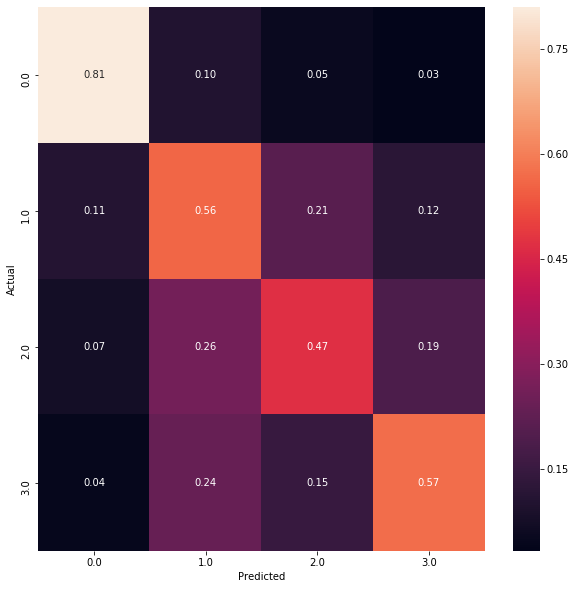

In [24]:
CLF_best_estimator = modelCLF_trained.best_estimator_
metrics_CLF = Metrics(CLF_best_estimator, X_test_original,Y_test__original)